## Практическая работа 12
### Задание
Реализовать метод гистограмм ориентированных градиентов HOG (см. библиотеку OpenImageR). Для этого сформировать библиотеку изображений, принадлежащих к одному классу и не принадлежащих к нему (не менее 10 изображений). Применить к ним метод. Сделать вывод о полученных результатах.

### Данные
Ссылка на пример датасета?

In [1]:
import os
import cv2
import numpy as np 
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from skimage import data, exposure

import pandas as pd

# from subprocess import check_output
# print(check_output(["ls", "./data"]).decode("utf8"))

### Загрузка данных

In [2]:
input_path_cow = 'data/cow/'
input_path_land = 'data/landscape/'
files_cow = os.listdir(f'{input_path_cow}')
files_land = os.listdir(f'{input_path_land}')
image = cv2.imread(f'{input_path_cow}/{files_cow[25]}')

In [3]:
image.shape

(189, 267, 3)

In [4]:
def img2hog(image):
    fd, hog_image = hog(
        image,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(4, 4),
        block_norm= 'L2',
        visualize=True,
        # channel_axis=-1
    )
    return fd, hog_image

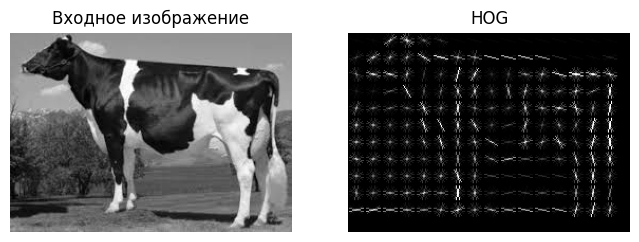

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fd, hog_image = hog(
    gray,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(4, 4),
    visualize=True,
    # channel_axis=-1
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(gray, cmap=plt.cm.gray)
ax1.set_title('Входное изображение')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 20))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG')
plt.show()

In [6]:
images1 = list()
images2 = list()
for file in files_cow:
    images1.append(cv2.imread(f'{input_path_cow}/{file}'))
for file in files_land:
    images2.append(cv2.imread(f'{input_path_land}/{file}'))
images = images1 + images2

In [7]:
hog_images = []
hog_features = []
for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (300, 150), interpolation = cv2.INTER_AREA)
    fd, hog_image = img2hog(resized)
    hog_images.append(hog_image)
    hog_features.append(fd)

In [8]:
labels1 = [1 for i in range(50)]
labels2 = [0 for i in range(50)]
hog_features = np.array(hog_features)
labels = np.array(labels1+labels2).reshape(100,1)
data_frame = np.hstack((hog_features,labels))
np.random.shuffle(data_frame)
print()

In [9]:
pd.DataFrame(data_frame).iloc[:, :10].sample(5)

,0,1,2,3,4,5,6,7,8,9
70,0.005020,0.002463,0.011266,0.001371,0.023908,0.000718,0.002429,0.000662,0.010377,0.006261
83,0.004544,0.000242,0.005379,0.009592,0.119603,0.008307,0.007975,0.000684,0.007909,0.000000
32,0.060620,0.091484,0.118406,0.076015,0.083498,0.030637,0.026693,0.023632,0.052671,0.009908
19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002511,0.000000
8,0.000000,0.000000,0.004609,0.005900,0.071164,0.000646,0.000000,0.000000,0.000433,0.001167


In [11]:
clf = svm.SVC()
percentage = 80
partition = int(len(hog_features)*percentage/100)

x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

clf.fit(x_train,y_train)
print()

In [12]:
y_pred = clf.predict(x_test)

In [13]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.75


              precision    recall  f1-score   support

         0.0       0.50      0.60      0.55         5
         1.0       0.86      0.80      0.83        15

    accuracy                           0.75        20
   macro avg       0.68      0.70      0.69        20
weighted avg       0.77      0.75      0.76        20



In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.8


              precision    recall  f1-score   support

         0.0       0.57      0.80      0.67         5
         1.0       0.92      0.80      0.86        15

    accuracy                           0.80        20
   macro avg       0.75      0.80      0.76        20
weighted avg       0.84      0.80      0.81        20



In [17]:
from catboost import CatBoostClassifier


model = CatBoostClassifier(task_type="GPU",
                           devices='0')
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Learning rate set to 0.038735
0:	learn: 0.6286270	total: 290ms	remaining: 4m 49s
1:	learn: 0.5794795	total: 511ms	remaining: 4m 15s
2:	learn: 0.5311311	total: 726ms	remaining: 4m 1s
3:	learn: 0.4841626	total: 939ms	remaining: 3m 53s
4:	learn: 0.4446078	total: 1.15s	remaining: 3m 49s
5:	learn: 0.4008066	total: 1.36s	remaining: 3m 45s
6:	learn: 0.3686699	total: 1.59s	remaining: 3m 45s
7:	learn: 0.3349769	total: 1.81s	remaining: 3m 44s
8:	learn: 0.3079412	total: 2.02s	remaining: 3m 42s
9:	learn: 0.2826883	total: 2.23s	remaining: 3m 40s
10:	learn: 0.2617917	total: 2.45s	remaining: 3m 40s
11:	learn: 0.2406578	total: 2.66s	remaining: 3m 39s
12:	learn: 0.2233613	total: 2.87s	remaining: 3m 38s
13:	learn: 0.2040069	total: 3.08s	remaining: 3m 37s
14:	learn: 0.1926815	total: 3.29s	remaining: 3m 36s
15:	learn: 0.1783851	total: 3.5s	remaining: 3m 35s
16:	learn: 0.1695528	total: 3.71s	remaining: 3m 34s
17:	learn: 0.1593172	total: 3.93s	remaining: 3m 34s
18:	learn: 0.1498940	total: 4.15s	remaining: 3